# Cuaderno de Entrenamiento del Modelo de Machine Learning

# Fase 1: Carga y Preparación de Datos

El primer paso es cargar los datos limpios y validados desde nuestra base de datos. Se seleccionan solo las columnas relevantes para la predicción de precios.

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import os
import sys
import json
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Añadir el directorio raíz al path para poder importar los módulos
# Esto nos permite hacer 'from src.ml...'
sys.path.append(os.path.abspath(os.path.join('..')))
from src.ml.feature_engineering import crear_features_nlp

# Ignorar advertencias futuras de pandas para una salida más limpia
warnings.simplefilter(action='ignore', category=FutureWarning)

# Cargar las variables de entorno desde el archivo .env en la raíz
load_dotenv(dotenv_path='../.env')

def get_data_from_db():
    """
    Se conecta a la base de datos usando SQLAlchemy y carga las columnas 
    relevantes para el modelo en un DataFrame.
    """
    try:
        db_user = os.getenv("DB_USER")
        db_password = os.getenv("DB_PASSWORD")
        db_host = os.getenv("DB_HOST")
        db_name = os.getenv("DB_NAME")
        
        db_uri = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}"
        engine = create_engine(db_uri)
        
        print("✅ Conectado a la base de datos. Cargando datos...")
        # MODIFICADO: Ahora también seleccionamos la columna 'description'
        query = """
            SELECT 
                price_usd, barrio, ambientes, dormitorios, banos, 
                superficie_total_m2, cocheras, description
            FROM propiedades
            WHERE price_usd IS NOT NULL AND superficie_total_m2 IS NOT NULL;
        """
        df = pd.read_sql(query, engine)
        print(f"✅ Se cargaron {len(df)} registros para el modelo.")
        return df
    except Exception as e:
        print(f"❌ Error al conectar o cargar datos desde MySQL: {e}")
        return None

# Cargar los datos para el modelo
df_modelo = get_data_from_db()

if df_modelo is not None:
    print("\nPrimeras 5 filas del DataFrame para el modelo:")
    display(df_modelo.head())


✅ Conectado a la base de datos. Cargando datos...
✅ Se cargaron 50248 registros para el modelo.

Primeras 5 filas del DataFrame para el modelo:


,price_usd,barrio,ambientes,dormitorios,banos,superficie_total_m2,cocheras,description
0,94500.0,Palermo,3,2,1,50,0,"Venta departamento de 3 ambientes con balcón, ..."
1,190000.0,Recoleta,4,3,1,93,1,Ventaluminoso departamento de 4 ambientes con ...
2,44500.0,Monserrat,2,1,1,29,0,Corredor Responsable: Ariel Champanier cucicba...
3,327420.0,Retiro,1,0,0,78,0,Departamento o estudio profesional.
4,345000.0,Belgrano,4,4,2,159,1,Corredor Responsable: Raul Hector Merlo cucicb...


# Fase 2: Pre-procesamiento y Feature Engineering

Ahora preparamos los datos para el entrenamiento:

    1. Generar Características NLP: Utilizar nuestro módulo feature_engineering para crear columnas booleanas a partir de la columna description.

    2. Unir y Limpiar: Combinar las nuevas features con el dataset original.

    3. Separar Features y Target: Dividir el DataFrame en nuestras características (X) y nuestra variable objetivo (y).

    4. One-Hot Encoding: Convertir la variable categórica barrio en un formato numérico.

In [2]:
if df_modelo is not None:
    # 1. Generar características NLP desde la columna 'description'
    print("Generando características NLP...")
    df_nlp_features = crear_features_nlp(df_modelo, 'description')
    print(f"✅ Se generaron {df_nlp_features.shape[1]} características NLP.")
    
    # 2. Unir las nuevas características con el DataFrame original
    df_enriquecido = pd.concat([df_modelo, df_nlp_features], axis=1)
    
    # 3. Separar características (X) y objetivo (y)
    # Se elimina 'description' porque ya fue procesada y 'price_usd' porque es el objetivo.
    X = df_enriquecido.drop(['price_usd', 'description'], axis=1)
    y = df_enriquecido['price_usd']
    
    print("\nCaracterísticas (X) iniciales (incluyendo NLP):")
    display(X.head())
    
    # 4. Convertir la variable categórica 'barrio' usando One-Hot Encoding
    if 'barrio' in X.columns:
        X_codificado = pd.get_dummies(X, columns=['barrio'], drop_first=True, dtype=int)
        
        print("\nCaracterísticas (X) después del One-Hot Encoding:")
        display(X_codificado.head())
        print(f"\nEl número total de columnas para el modelo es: {X_codificado.shape[1]}")


Generando características NLP...
✅ Se generaron 11 características NLP.

Características (X) iniciales (incluyendo NLP):


,barrio,ambientes,dormitorios,banos,superficie_total_m2,cocheras,feature_balcon,feature_luminoso,feature_seguridad,feature_pileta,feature_gimnasio,feature_sum,feature_parrilla,feature_estrenar,feature_reciclado,feature_cochera,feature_amenities
0,Palermo,3,2,1,50,0,0,0,0,0,0,0,0,0,1,0,0
1,Recoleta,4,3,1,93,1,0,1,0,0,0,0,0,0,0,1,0
2,Monserrat,2,1,1,29,0,0,0,0,0,0,1,0,0,0,0,0
3,Retiro,1,0,0,78,0,0,0,0,0,0,0,0,0,0,0,0
4,Belgrano,4,4,2,159,1,0,1,1,0,0,1,0,0,1,0,0



Características (X) después del One-Hot Encoding:


,ambientes,dormitorios,banos,superficie_total_m2,cocheras,feature_balcon,feature_luminoso,feature_seguridad,feature_pileta,feature_gimnasio,...,barrio_Villa Lugano,barrio_Villa Luro,barrio_Villa Ortuzar,barrio_Villa Pueyrredon,barrio_Villa Real,barrio_Villa Riachuelo,barrio_Villa Santa Rita,barrio_Villa Soldati,barrio_Villa Urquiza,barrio_Villa del Parque
0,3,2,1,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,3,1,93,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,78,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,2,159,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0



El número total de columnas para el modelo es: 63


In [3]:
# 2. Convertir la variable categórica 'barrio' usando One-Hot Encoding
if 'barrio' in X.columns:
    X_codificado = pd.get_dummies(X, columns=['barrio'], drop_first=True, dtype=int)
    
    print("\nCaracterísticas (X) después del One-Hot Encoding:")
    display(X_codificado.head())
    
    print(f"\nEl número de columnas aumentó de {X.shape[1]} a {X_codificado.shape[1]}.")


Características (X) después del One-Hot Encoding:


,ambientes,dormitorios,banos,superficie_total_m2,cocheras,feature_balcon,feature_luminoso,feature_seguridad,feature_pileta,feature_gimnasio,...,barrio_Villa Lugano,barrio_Villa Luro,barrio_Villa Ortuzar,barrio_Villa Pueyrredon,barrio_Villa Real,barrio_Villa Riachuelo,barrio_Villa Santa Rita,barrio_Villa Soldati,barrio_Villa Urquiza,barrio_Villa del Parque
0,3,2,1,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,3,1,93,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,78,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,2,159,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0



El número de columnas aumentó de 17 a 63.


# Fase 3: División de Datos en Conjuntos de Entrenamiento y Prueba
 
Para evaluar el rendimiento de nuestro modelo de manera objetiva, debemos dividir nuestros datos en dos conjuntos:
   
    - 1.  **Conjunto de Entrenamiento (Training Set)**: La mayor parte de los datos, que usaremos para que el modelo aprenda.
    - 2.  **Conjunto de Prueba (Testing Set):** Una pequeña porción que mantendremos "oculta" para el modelo. La usaremos al final para ver qué tan bien generaliza a datos que nunca ha visto.


In [4]:
from sklearn.model_selection import train_test_split

if 'X_codificado' in locals():
    # Dividimos los datos: 80% para entrenamiento, 20% para prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X_codificado, 
        y, 
        test_size=0.2, 
        random_state=42  # random_state asegura que la división sea siempre la misma
    )
    
    print("División de datos completada.")
    print(f"Tamaño del conjunto de entrenamiento (X_train): {X_train.shape}")
    print(f"Tamaño del conjunto de prueba (X_test): {X_test.shape}")
    print(f"Tamaño del objetivo de entrenamiento (y_train): {y_train.shape}")
    print(f"Tamaño del objetivo de prueba (y_test): {y_test.shape}")



División de datos completada.
Tamaño del conjunto de entrenamiento (X_train): (40198, 63)
Tamaño del conjunto de prueba (X_test): (10050, 63)
Tamaño del objetivo de entrenamiento (y_train): (40198,)
Tamaño del objetivo de prueba (y_test): (10050,)


# Fase 4: Entrenamiento y Evaluación del Modelo Base

## Entrenamos el RandomForestRegressor con el nuevo conjunto de datos que incluye las features de NLP y medimos su rendimiento (RMSE y R²).

In [5]:
if 'X_train' in locals():
    print("Entrenando el modelo RandomForestRegressor enriquecido...")
    modelo_enriquecido = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    modelo_enriquecido.fit(X_train, y_train)
    print("✅ Modelo entrenado con éxito.")
    
    print("\nRealizando predicciones en el conjunto de prueba...")
    y_pred = modelo_enriquecido.predict(X_test)
    
    print("Evaluando el rendimiento del modelo...")
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n--- Resultados de Evaluación del Modelo Enriquecido ---")
    print(f"RMSE (Error Cuadrático Medio Raíz): ${rmse:,.2f} USD")
    print(f"R² (Coeficiente de Determinación): {r2:.4f}")

Entrenando el modelo RandomForestRegressor enriquecido...
✅ Modelo entrenado con éxito.

Realizando predicciones en el conjunto de prueba...
Evaluando el rendimiento del modelo...

--- Resultados de Evaluación del Modelo Enriquecido ---
RMSE (Error Cuadrático Medio Raíz): $152,468.91 USD
R² (Coeficiente de Determinación): 0.8765


# Fase 5: Análisis de Resultados y Persistencia

Visualizamos los resultados y guardamos los artefactos actualizados (model.pkl, model_columns.pkl, metrics.json) para ponerlos en producción.

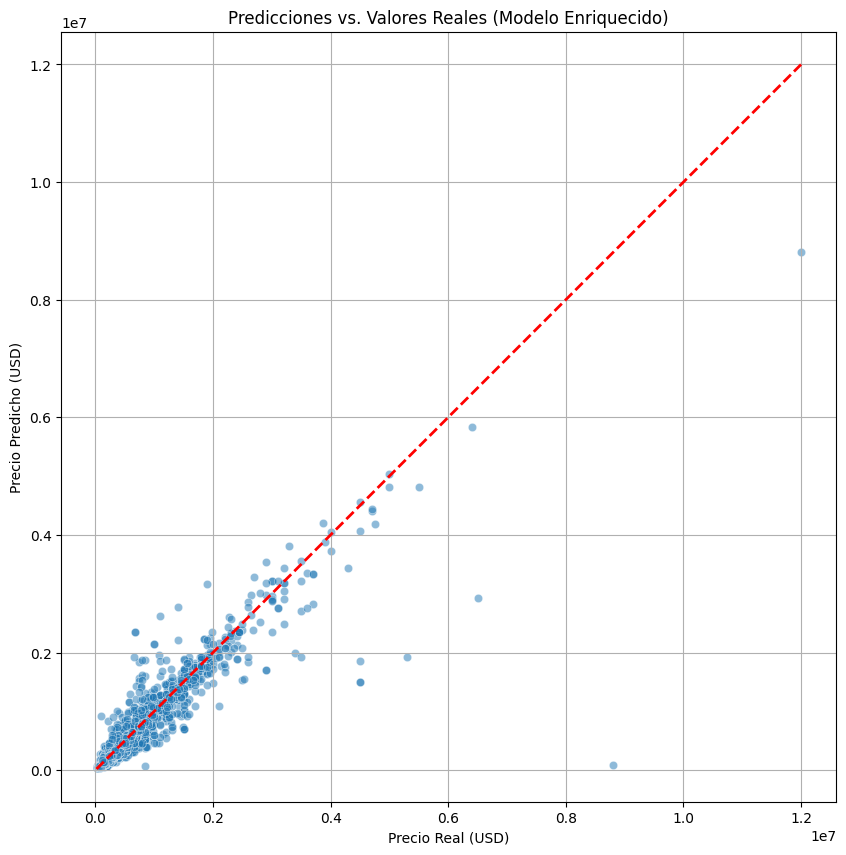

In [6]:
if 'y_test' in locals() and 'y_pred' in locals():
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    
    max_val = max(y_test.max(), y_pred.max())
    min_val = min(y_test.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2)
    
    plt.title('Predicciones vs. Valores Reales (Modelo Enriquecido)')
    plt.xlabel('Precio Real (USD)')
    plt.ylabel('Precio Predicho (USD)')
    plt.axis('equal')
    plt.grid(True)
    plt.show()


In [7]:
if 'modelo_enriquecido' in locals() and 'X_codificado' in locals() and 'r2' in locals():
    model_dir = '../src/ml/'
    os.makedirs(model_dir, exist_ok=True)
    
    # 1. Guardar el modelo enriquecido
    model_path = os.path.join(model_dir, 'model.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(modelo_enriquecido, f)
    print(f"✅ Modelo enriquecido guardado en: {model_path}")
    
    # 2. Guardar la nueva lista de columnas
    columns_path = os.path.join(model_dir, 'model_columns.pkl')
    model_columns = list(X_codificado.columns)
    with open(columns_path, 'wb') as f:
        pickle.dump(model_columns, f)
    print(f"✅ Nuevas columnas del modelo guardadas en: {columns_path}")
        
    # 3. Guardar las nuevas métricas
    metrics_path = os.path.join(model_dir, 'metrics.json')
    metrics = {
        "r2_score": r2,
        "rmse_usd": rmse
    }
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"✅ Nuevas métricas del modelo guardadas en: {metrics_path}")

✅ Modelo enriquecido guardado en: ../src/ml/model.pkl
✅ Nuevas columnas del modelo guardadas en: ../src/ml/model_columns.pkl
✅ Nuevas métricas del modelo guardadas en: ../src/ml/metrics.json
